In [1]:
! pip3 install -r requirements.txt --quiet
! pip3 install snntorch --quiet

ERROR: Could not open requirements file: [Errno 2] No such file or directory: 'requirements.txt'


In [87]:
import snntorch as snn
from snntorch import spikeplot as splt
from snntorch import spikegen
from scipy.io import loadmat
import numpy as np
import torch
from torch import nn, optim
import torch.nn.functional as F
import statistics
import os
import matplotlib.pyplot as plt
import scipy.stats
import math 
import sklearn
from sklearn import metrics
from snntorch import functional as SF

In [88]:
# Set number of time steps that the model will simulate. The spike times will be compressed into this timeframe. 
# Number must be greater than the largest spike count in a cell in the rat brain during the simulation, larger slows processing time, 
#but improves accuracy of spike time mappings 
num_steps = 500

In [89]:
def normalize(i, min, max):
    return (i - min) / (max - min)

# Hasher function used to compress spike times into our simulation time. Simple implimentation. 
# n: size of output array. Should equal to num_steps
# arr: The array to be hashed
# min/ max: Maximum and minimum values in input array. Max should be very slightly higher than the actually number, otherwise indexing errors can occur. 
# output: New hashed array of size n 
# Input is an array containing the 'time stamps' ie 1.01 for a spike occuring 1.01 seconds into simulation 
# This function than turns that spike into a '1' in an array of n indices, where i now becomes time 
def hasher(n, arr, min=0., max=2.0001):
    if len(arr) > n:
        print("There is too many items in this array to hash")
        print(f"The num_steps is {n} and the array length is {len(arr)}")
        print("Inserting an array full of ones instead")
        return np.ones(n)

    back_flag = False
    out = np.zeros(n)
    for item in arr: 
        norm = normalize(item, min, max)
        #print(norm)
        index = math.floor(norm * n)
        while out[index] == 1:
            if index == 0:
                back_flag = False
            if index == n-1:
                    back_flag = True

            if back_flag: 
                index -= 1 
                if index == 0:
                    back_flag = False
            else:
                index += 1 
                if index == n-1:
                    back_flag = True

        back_flag = False 
        
        out[index] = 1

    return out

In [90]:
# unpack_hash: 
# data: input the contents of one brain region from mat file 
# output: the contents of that file, now in in a singular array instead of nested lists and arrays 
# hashed via hash function above 

def unpack_hash(data):
    data = np.array(data[0])
    unpacked = [hasher(num_steps, item[0].flatten()) for item in data] 
    arr = np.array(unpacked)

    return np.fliplr(np.rot90(arr, -1))


In [91]:
#pass list of matfiles and elem to find maxlen of that attribute 
def max_len(mat_list, elem):
    max_elem = 0 
    for mat in mat_list:
        data = mat[elem]
        temp = max([len(item[0]) for item in data[0]])
        
        if(max_elem < temp):
            max_elem = temp 

    return max_elem

#pass list of matfiles and optional integer 'wiggle' 
#first, each matfile is passed through max_len function for each attribute of concern 
#wiggle is added to end of calculated maxlen. This is to ensure no problems arrive if testing data has some elements longer than training 
# TODO: some way to pass calculated maxlens to testdata will be important, so vector size is consistent between training and testing sets 
# then each file in mat_list is unpacked, and appended to each other to create one vector for each matfile 
# list of input vectors returned 

def constructor_hash(mat_list):
    out = []

    for mat in mat_list:
        TH_APs_data = unpack_hash(mat['TH_APs'])
        STNAPs_data = unpack_hash(mat['STN_APs'])
        GPe_APs_data = unpack_hash(mat['GPe_APs'])
        GPi_APs_data = unpack_hash(mat['GPi_APs'])
        Striat_APs_indr_data = unpack_hash(mat['Striat_APs_indr'])
        Striat_APs_dr_data = unpack_hash(mat['Striat_APs_dr'])
        Cor_APs_data = unpack_hash(mat['Cor_APs'])

        build = np.append(TH_APs_data, STNAPs_data, axis=1)
        build = np.append(build, GPe_APs_data, axis=1)
        build = np.append(build, GPi_APs_data, axis=1)
        build = np.append(build, Striat_APs_indr_data, axis=1)
        build = np.append(build, Striat_APs_dr_data, axis=1)
        build = np.append(build, Cor_APs_data, axis=1)
        out = out + [build]
        
    return np.array(out)

# pass dir = Directory containing samples 
# mat = name of the mat file you want to open 
def open_mat(dir, mat_name): 
    filename = os.path.join(dir, mat_name)
    mat = loadmat(filename)
    return mat

# input: list of mat files
# output: List of all gpi_alpha_beta_area's from mat files 

def get_beta_oscilation(mat_list):
    out = [] 
    for mat in mat_list: 
        out = out + [mat["gpi_alpha_beta_area"][0][0]]

    return out 

# dir = directory to load (ie Training Validation Set)
# os.loadir() loads all the filenames in a given directory
def load_dir(dir): 
    out = []
    bin_labels = [] 
    for mat_file in os.listdir(dir):
        if 'con' in mat_file:
            out = out + [open_mat(dir, mat_file)]
            bin_labels = bin_labels + [0]
        elif 'pd' in mat_file:
            out = out + [open_mat(dir, mat_file)]
            bin_labels = bin_labels + [1]
    
    alpha_beta = get_beta_oscilation(out) 
    out = constructor_hash(out)
    labels = list(zip(alpha_beta, bin_labels))
    
    return out, labels  


In [92]:
# set device
# NOTE: programmed on device without cuda. If device issues arise, ensure all relevant items properly cast to device
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
# set batch size
batch_size = 32

# Open directory specified, and cast build dataloader 
def build_dataloader(dir):
    full_dir, labels = load_dir(dir)
    data_tensor = torch.Tensor(full_dir).to(device)
    print(data_tensor.size())
    label_tensor = torch.Tensor(labels).to(device)
    dataset = torch.utils.data.TensorDataset(data_tensor, label_tensor)
    data = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)
    return data 

data = build_dataloader(os.path.join('Datasets', "rat_pd_sim_data\\VariedTrainingData"))



torch.Size([460, 500, 80])


In [93]:
data_list = list(data)
item, targets = data_list[0]
print(f"Shape of item tensor: {item.shape}")
print(f'This represents a batch size of {len(item)}, each sample in a batch is over {len(item[0])} timesteps, and has {len(item[0][0])} simulated cells\n')
print(f"Shape of targets tensor: {targets.shape}")
print(f'This represents a batch size of {len(item)}, each batch has a corresponding target label that is a tuple of size {len(item[0])} where index 0')
print('of that tuple is the alpha-beta oscillation and the index 1 of that tuple is a label 0 (no PD) or 1 (PD)')

Shape of item tensor: torch.Size([32, 500, 80])
This represents a batch size of 32, each sample in a batch is over 500 timesteps, and has 80 simulated cells

Shape of targets tensor: torch.Size([32, 2])
This represents a batch size of 32, each batch has a corresponding target label that is a tuple of size 500 where index 0
of that tuple is the alpha-beta oscillation and the index 1 of that tuple is a label 0 (no PD) or 1 (PD)


In [94]:
class Net_small(nn.Module):
    def __init__(self, num_inputs, num_hidden, beta, num_outputs, num_steps, batch_size):
        super().__init__()
        self.num_inputs = num_inputs 
        self.num_hidden = num_hidden 
        self.beta = beta 
        self.num_outputs = num_outputs 
        self.num_steps = num_steps
        self.batch_size = batch_size 

        # Initialize layers
        self.fc1 = nn.Linear(num_inputs, num_hidden)
        self.lif1 = snn.Leaky(beta=beta)
        self.fc2 = nn.Linear(num_hidden, num_hidden)
        self.lif2 = snn.Leaky(beta=beta)
        self.fc3 = nn.Linear(num_hidden, num_hidden)
        self.lif3 = snn.Leaky(beta=beta)
        self.fc4 = nn.Linear(num_hidden, num_outputs)
        self.lif4 = snn.Leaky(beta=beta)

    def forward(self, x):

        # Initialize hidden states at t=0
        mem1 = self.lif1.init_leaky()
        mem2 = self.lif2.init_leaky()
        mem3 = self.lif3.init_leaky()
        mem4 = self.lif4.init_leaky()
        
        # Record the final layer
        spk1_rec = []
        spk2_rec = []
        spk3_rec = []
        spk4_rec = []
        mem4_rec = [] 

        for step in range(self.num_steps):
            cur1 = self.fc1(x[0:self.batch_size, step, 0:self.num_inputs]) 
            spk1, mem1 = self.lif1(cur1, mem1)
            spk1_rec.append(spk1)
            cur2 = self.fc2(spk1)
            spk2, mem2 = self.lif2(cur2, mem2)
            spk2_rec.append(spk2)
            cur3 = self.fc3(spk2)
            spk3, mem3 = self.lif3(cur3, mem3)
            spk3_rec.append(spk3)
            cur4 = self.fc4(spk3)
            spk4, mem4 = self.lif4(cur4, mem4)
            spk4_rec.append(spk4)
            mem4_rec.append(mem4)
        

        spk1_rec = torch.stack(spk1_rec)
        spk2_rec = torch.stack(spk2_rec)
        spk3_rec = torch.stack(spk3_rec)
        spk4_rec = torch.stack(spk4_rec)
        
        return [spk1_rec, spk2_rec, spk3_rec, spk4_rec], mem4

In [95]:
#num_inputs, num_hidden, beta, num_outputs, num_steps, batch_size, input_width 
import torch.nn as nn
import snntorch as snn 
import torch 
class Neuron_soup(nn.Module):
    def __init__(self, num_inputs, num_hidden, beta, num_outputs, num_steps, batch_size, input_width):
        super().__init__()
        self.num_steps = num_steps 
        self.batch_size = batch_size 
        self.input_width = input_width 
        self.num_layers = 4 
        self.num_possible_paths = (self.num_layers - 2) * num_hidden + num_outputs + num_inputs 

        # Initialize layers
        self.fc1 = nn.Linear(num_inputs + (num_hidden * 2) + num_outputs, num_hidden)
        self.lif1 = snn.Leaky(beta=beta)
        self.fc2 = nn.Linear((num_hidden * 2) + num_outputs, num_hidden)
        self.lif2 = snn.Leaky(beta=beta)
        self.fc3 = nn.Linear((num_hidden * 2) + num_outputs, num_hidden)
        self.lif3 = snn.Leaky(beta=beta)
        self.fc4 = nn.Linear((num_hidden * 3), num_outputs)
        self.lif4 = snn.Leaky(beta=beta)

        self.prev_spk2 = torch.zeros(batch_size, num_hidden)
        
        #print(f'zeroes_tensor: {self.prev_spk2.size()}')
        self.prev_spk3 = torch.zeros(batch_size, num_hidden) 
        self.prev_spk4 = torch.zeros(batch_size, num_outputs)

    def forward(self, x):

        # Initialize hidden states at t=0
        mem1 = self.lif1.init_leaky()
        mem2 = self.lif2.init_leaky()
        mem3 = self.lif3.init_leaky()
        mem4 = self.lif4.init_leaky()
        
        # Record the final layer
        spk1_rec = []
        spk2_rec = []
        spk3_rec = []
        spk4_rec = []
        mem4_rec = [] 
        prev_spk2 = self.prev_spk2 
        prev_spk3 = self.prev_spk3
        prev_spk4 = self.prev_spk4 

        in_size = x.size()[0]

        if(in_size < self.batch_size): 
            x = torch.cat((x, torch.zeros((self.batch_size - in_size, self.num_steps, self.input_width))))

        for step in range(self.num_steps):
            #print(f'forward tensor: {x[0:self.batch_size, step, 0:self.input_width].size()}')
            #print(f'combined input tensor: {torch.cat((x[0:self.batch_size, step, 0:self.input_width], prev_spk2, prev_spk3, prev_spk4), dim=1).size()}')
            cur1 = self.fc1(torch.cat((x[0:self.batch_size, step, 0:self.input_width], prev_spk2.detach(), prev_spk3.detach(), prev_spk4.detach()), dim=1)) 
            spk1, mem1 = self.lif1(cur1, mem1)
            spk1_rec.append(spk1)
            #print(f'layer 2 input: {torch.cat((spk1, prev_spk3, prev_spk4), dim=1).size()}')
            cur2 = self.fc2(torch.cat((spk1, prev_spk3.detach(), prev_spk4.detach()), dim=1))
            spk2, mem2 = self.lif2(cur2, mem2)
            spk2_rec.append(spk2)
            cur3 = self.fc3(torch.cat((spk1, spk2, prev_spk4.detach()), dim=1))
            spk3, mem3 = self.lif3(cur3, mem3)
            spk3_rec.append(spk3)
            cur4 = self.fc4(torch.cat((spk1, spk2, spk3), dim=1))
            spk4, mem4 = self.lif4(cur4, mem4)
            spk4_rec.append(spk4)
            mem4_rec.append(mem4)
            prev_spk2 = spk2_rec[len(spk2_rec) - 1] 
            prev_spk3 = spk3_rec[len(spk3_rec) - 1]
            prev_spk4 = spk4_rec[len(spk4_rec) - 1]
        
        self.prev_spk2 = prev_spk2
        self.prev_spk3 = prev_spk3
        self.prev_spk4 = prev_spk4
        
        spk1_rec = torch.stack(spk1_rec)
        spk2_rec = torch.stack(spk2_rec)
        spk3_rec = torch.stack(spk3_rec)
        spk4_rec = torch.stack(spk4_rec)

        if(in_size < self.batch_size): 
            mem4 = mem4[0:in_size]
        
        return [spk1_rec, spk2_rec, spk3_rec, spk4_rec], mem4
    





In [96]:
from einops import einsum
import snntorch as snn 
import torch 
import torch.nn as nn 

# .memory source: https://github.com/facebookresearch/XLM/blob/main/xlm/model
from einops.layers.torch import Rearrange
import torch.nn.functional as F

DEBUG = False

def debug(input):
    if DEBUG: 
        print(input)
def debug_exit():
    assert(DEBUG==False)

class Printer(nn.Module): 
    def __init__(self): 
        super().__init__() 

    def forward(self, input): 
        print(input.size())
        return input

def exists(v):
    return v is not None

def default(v, d):
    return v if exists(v) else d

class RMSNorm(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.scale = dim ** 0.5
        self.gamma = nn.Parameter(torch.ones(dim))

    def forward(self, x):
        return F.normalize(x, dim=-1) * self.scale * self.gamma

class ProductKeyMemory(nn.Module):
    def __init__(self, dim, num_keys):
        super().__init__()
        self.dim = dim
        self.num_keys = num_keys
        self.keys = nn.Parameter(torch.randn(num_keys, dim // 2))
        
    def forward(self, query):
        query = query.view(query.shape[0], 2, -1)
        dots = torch.einsum('bkd,nd->bkn', query, self.keys)
        return dots.view(query.shape[0], -1)

class PEER(nn.Module):
    def __init__(
        self,
        dim,
        *,
        heads=8,
        num_experts=1_000_000,
        num_experts_per_head=16,
        activation=nn.GELU,
        dim_key=None,
        product_key_topk=None,
        separate_embed_per_head=False,
        pre_rmsnorm=False,
        dropout=0.
    ):
        super().__init__()

        self.norm = RMSNorm(dim) if pre_rmsnorm else nn.Identity()

        self.heads = heads
        self.separate_embed_per_head = separate_embed_per_head
        self.num_experts = num_experts

        num_expert_sets = heads if separate_embed_per_head else 1

        self.weight_down_embed = nn.Embedding(num_experts * num_expert_sets, dim)
        self.weight_up_embed = nn.Embedding(num_experts * num_expert_sets, dim)

        self.activation = activation

        assert (num_experts ** 0.5).is_integer(), '`num_experts` needs to be a square'
        assert (dim % 2) == 0, 'feature dimension should be divisible by 2'

        dim_key = default(dim_key, dim // 2)
        self.num_keys = int(num_experts ** 0.5)

        self.to_queries = nn.Sequential(
            nn.Linear(dim, dim_key * heads * 2, bias=False),
            Rearrange('b (p d) -> p b d', p=2)
        )

        self.product_key_topk = default(product_key_topk, num_experts_per_head)
        self.num_experts_per_head = num_experts_per_head

        self.keys = nn.Parameter(torch.randn(heads, self.num_keys, 2, dim_key))

        self.dropout = nn.Dropout(dropout)

    def forward(self, x, membrain):
        x = self.norm(x)
        debug(f'x.shape: {x.shape}')
        queries = self.to_queries(x)
        debug(f'queries.size: {queries.size()}')
        debug(f'self.keys.size(): {self.keys.size()}')

        sim = einsum(queries, self.keys, 'p b d, h k p d -> p b h k')
        debug(f'sim.size() {sim.size()}')
        

        (scores_x, scores_y), (indices_x, indices_y) = [s.topk(self.product_key_topk, dim=-1) for s in sim]
        debug(f'scores_x.size() {scores_x.size()}')
        

        all_scores = scores_x.unsqueeze(-1) + scores_y.unsqueeze(-2)
        all_indices = indices_x.unsqueeze(-1) * self.num_keys + indices_y.unsqueeze(-2)
        debug(f'all_score.size() {all_scores.size()}')
        debug(f'all_indices.size() {all_indices.size()}')


        all_scores = all_scores.view(*all_scores.shape[:-2], -1)
        all_indices = all_indices.view(*all_indices.shape[:-2], -1)
        debug(f'all_score.size (post view) {all_scores.size()}')
        debug(f'all_indices.size (post view) {all_indices.size()}')
        debug(all_scores[-1])
        

        scores, pk_indices = all_scores.topk(self.num_experts_per_head, dim=-1)
        debug(f'scores.size {scores.size()}')
        debug(f'pk_indices.size {pk_indices.size()}')
        indices = all_indices.gather(-1, pk_indices)
        debug(f'indices.size {indices.size()}')

        debug_exit() 

        if self.separate_embed_per_head:
            head_expert_offsets = torch.arange(self.heads, device=x.device) * self.num_experts
            indices = indices + head_expert_offsets.view(1, 1, -1, 1)

        weights_down = self.weight_down_embed(pk_indices)
        weights_up = self.weight_up_embed(pk_indices)

        x = einsum(x, weights_down, 'b d, b n k d -> b n k')

        x, membrain = self.activation(x) # x is now spike outputs of the LIF neuron, membrain potentials are stored in membrain 
        x = self.dropout(x)

        x = x * F.softmax(scores, dim=-1)

        x = einsum(x, weights_up, 'b n k, b n k d -> b d')

        return x, membrain 
    
    def init_leaky(self):
        return self.activation.init_leaky() 



'''
def forward(self, x):
    b, s = x.shape
    positions = torch.arange(s, device=x.device).unsqueeze(0).expand(b, s)
    
    x = self.token_embedding(x) + self.position_embedding(positions)
    
    for layer in self.layers:
        x = layer(x)
    
    x = self.layer_norm(x)
    logits = self.lm_head(x)
    return logits
'''
class MOME_net(nn.Module):
    def __init__(self, num_inputs, num_hidden, beta, num_outputs, num_steps, batch_size, key_topk=2, per_head_topk=4):
        super().__init__()
        self.num_steps = num_steps 
        self.batch_size = batch_size 
        self.num_inputs = num_inputs 

        # Initialize layers
        self.fc1 = nn.Linear(num_inputs, num_hidden)
        self.lif1 = snn.Leaky(beta=beta)
        self.p1 = MOME_layer(num_hidden, num_hidden, beta=beta, key_topk=key_topk, per_head_topk=per_head_topk)
        self.p2 = MOME_layer(num_hidden, num_hidden, beta=beta, key_topk=key_topk, per_head_topk=per_head_topk)
        # self.p3 = MOME_layer(num_hidden, num_hidden, beta=beta)
        # self.p4 = MOME_layer(num_outputs, num_outputs, beta=beta)
        self.fc2 = nn.Linear(num_hidden, num_outputs)
        self.lif2 = snn.Leaky(beta=beta)

    def forward(self, x):

        # Initialize hidden states at t=0
        mem1 = self.lif1.init_leaky() 
        mem2 = self.p1.init_leaky()
        mem3 = self.p2.init_leaky()
        mem4 = self.lif2.init_leaky() 
        # mem3 = self.p3.init_leaky()
        # mem4 = self.p4.init_leaky()
        
        # Record the final layer
        spk1_rec = []
        spk2_rec = []
        spk3_rec = []
        spk4_rec = []
        mem4_rec = [] 

        for step in range(self.num_steps):
            cur1 = self.fc1(x[0:self.batch_size, step, 0:self.num_inputs]) 
            spk1, mem1 = self.lif1(cur1, mem1)
            spk1_rec.append(spk1)
            spk2, mem2 = self.p1(spk1, mem2)
            spk2_rec.append(spk2)
            spk3, mem3 = self.p2(spk2, mem3)
            spk3_rec.append(spk3)
            cur2 = self.fc2(spk3)
            spk4, mem4 = self.lif2(cur2, mem4)
            spk4_rec.append(spk4)
            mem4_rec.append(mem4)
        

        spk1_rec = torch.stack(spk1_rec)
        spk2_rec = torch.stack(spk2_rec)
        spk3_rec = torch.stack(spk3_rec)
        spk4_rec = torch.stack(spk4_rec)
        
        return [spk1_rec, spk2_rec, spk3_rec, spk4_rec], mem4
    


# https://github.com/facebookresearch/XLM/blob/main/xlm/model/transformer.py 
# top k selection involves generating a k value for each expert, that allows evaluation of which expert is best for a specific task 
# this is the most complex portion of a mixture of experts model 
# Each MOME layer must make a selection of experts each time 
'''
        self,
        dim, -> num inputs 
        *,
        heads=8,
        num_experts=1_000_000,-> also num inputs? 
        num_experts_per_head=16, -> other num outputs 
        activation=nn.GELU,
        dim_key=None,
        product_key_topk=None, -> num outputs 
        separate_embed_per_head=False,
        pre_rmsnorm=False,
        dropout=0.
'''
class MOME_layer(nn.Module):
    def __init__(self, num_inputs: int, num_outputs: int, beta, key_topk=2, per_head_topk=4): 
        super().__init__()
        self.num_experts = num_inputs

        self.peer = PEER(num_inputs, heads=1, num_experts=self.num_experts, product_key_topk=key_topk, activation=snn.Leaky(beta=beta), num_experts_per_head=per_head_topk)

    def forward(self, data, mem):
        data, mem = self.peer(data, mem)
        
        return data, mem
    
    def init_leaky(self):
        return self.peer.init_leaky() 
    



In [97]:
def count_spike(spikes): 
    output = []
    unpacked = []
    for item in spikes: 
        # time * batch * neurons 
        # sum in time and neuron dimensions 
        unpacked.append(item.sum(0).sum(-1))
        #gives spike count by batch 
        #print(item.sum(0).sum(-1).size())
    for i in range(unpacked[0].size()[0]): 
        count = 0
        for item in unpacked:
            count += item[i] 
        
        output.append(count)
    return torch.stack(output)
    

In [98]:

def train_loop(data, model, num_epochs, loss, optimizer):
    loss_hist = []
    dtype = torch.float
    loss_by_epoch = [] 
    spk_hist = [] 

    # Outer training loop
    for epoch in range(num_epochs):
        epoch_loss = [] 
        #iter_counter = 0

        # Minibatch training loop
        for i, (item, targets) in enumerate(iter(data)):
            targets = targets[0:batch_size, 1:2]
            targets = targets.flatten()

            targets = targets.type(torch.long)

            # forward pass
            model.train()
            spk_rec, mem_rec = model(item)
            spk_hist.append(spk_rec) 

            # initialize the loss & sum over time
            loss_val = torch.zeros((1), dtype=dtype, device=device)

            loss_val = torch.sum(loss(mem_rec, targets))

            # Gradient calculation + weight update
            optimizer.zero_grad()
            loss_val.backward(retain_graph=True)
            optimizer.step()

            # Store loss history for future plotting
            loss_hist.append(loss_val.item())
            epoch_loss.append(loss_val.item())

            # Calculate accuracy without SF.accuracy_rate
            pred = torch.argmax(mem_rec.detach(), dim=1)
            accuracy = metrics.accuracy_score(targets.detach(), pred)

            # Print accuracy
            if loss_val.item() > 0.001:
                if i % 2 == 0:
                    print(f"Epoch {epoch}, Iteration {i}, Train Loss: {loss_val.item():.2f}, Accuracy: {accuracy * 100:.2f}%")
            else:
                if i % 20 == 0:
                    print(f"Epoch {epoch}, Iteration {i}, Train Loss: {loss_val.item():.2f}, Accuracy: {accuracy * 100:.2f}%")

        loss_by_epoch.append(epoch_loss)
    
    return (loss_hist, loss_by_epoch, spk_hist)
        




In [99]:
num_hidden = 36
num_inputs = 80 
num_outputs = 2
beta = .95 

In [100]:
num_epochs = 5

# keytopk^2 <= per_head_topk
mome_net = MOME_net(num_inputs=num_inputs, num_hidden=num_hidden, beta=beta, num_outputs=num_outputs, num_steps=num_steps, batch_size=batch_size, key_topk=4, per_head_topk=4).to(device)
loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(mome_net.parameters(), lr=0.001, betas=(0.9, 0.999))
loss_hist_mome, loss_by_epoch_mome, spk_hist = train_loop(data, mome_net, num_epochs, loss, optimizer)

Epoch 0, Iteration 0, Train Loss: 0.42, Accuracy: 87.50%
Epoch 0, Iteration 2, Train Loss: 0.26, Accuracy: 93.75%
Epoch 0, Iteration 4, Train Loss: 0.32, Accuracy: 90.62%
Epoch 0, Iteration 6, Train Loss: 0.13, Accuracy: 96.88%
Epoch 0, Iteration 8, Train Loss: 0.28, Accuracy: 90.62%
Epoch 0, Iteration 10, Train Loss: 0.06, Accuracy: 100.00%
Epoch 0, Iteration 12, Train Loss: 0.54, Accuracy: 78.12%
Epoch 0, Iteration 14, Train Loss: 0.25, Accuracy: 91.67%
Epoch 1, Iteration 0, Train Loss: 0.36, Accuracy: 81.25%
Epoch 1, Iteration 2, Train Loss: 0.25, Accuracy: 90.62%
Epoch 1, Iteration 4, Train Loss: 0.18, Accuracy: 93.75%
Epoch 1, Iteration 6, Train Loss: 0.21, Accuracy: 93.75%
Epoch 1, Iteration 8, Train Loss: 0.17, Accuracy: 93.75%
Epoch 1, Iteration 10, Train Loss: 0.12, Accuracy: 96.88%
Epoch 1, Iteration 12, Train Loss: 0.19, Accuracy: 90.62%
Epoch 1, Iteration 14, Train Loss: 0.15, Accuracy: 91.67%
Epoch 2, Iteration 0, Train Loss: 0.25, Accuracy: 87.50%
Epoch 2, Iteration 2, Tr

In [101]:
soup_net = Neuron_soup(num_inputs=num_inputs, num_hidden=num_hidden, beta=beta, num_outputs=num_outputs, num_steps=num_steps, batch_size=batch_size, input_width=80).to(device)
loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(soup_net.parameters(), lr=0.001, betas=(0.9, 0.999))
#loss_hist_soup, loss_by_epoch_soup, spk_hist = train_loop(data, soup_net, num_epochs, loss, optimizer)
#print(num_hidden + num_hidden + num_outputs + num_inputs)
#print((num_hidden * 2) + num_outputs)

In [102]:
net = Net_small(num_inputs=num_inputs, num_hidden=num_hidden, beta=beta, num_outputs=num_outputs, num_steps=num_steps, batch_size=batch_size)
loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.001, betas=(0.9, 0.999))
loss_hist, loss_by_epoch, spk_hist_base = train_loop(data, net, num_epochs, loss, optimizer)

Epoch 0, Iteration 0, Train Loss: 0.78, Accuracy: 31.25%
Epoch 0, Iteration 2, Train Loss: 0.78, Accuracy: 43.75%
Epoch 0, Iteration 4, Train Loss: 0.69, Accuracy: 46.88%
Epoch 0, Iteration 6, Train Loss: 0.75, Accuracy: 37.50%
Epoch 0, Iteration 8, Train Loss: 0.68, Accuracy: 59.38%
Epoch 0, Iteration 10, Train Loss: 0.76, Accuracy: 37.50%
Epoch 0, Iteration 12, Train Loss: 0.67, Accuracy: 56.25%
Epoch 0, Iteration 14, Train Loss: 0.62, Accuracy: 66.67%
Epoch 1, Iteration 0, Train Loss: 0.61, Accuracy: 71.88%
Epoch 1, Iteration 2, Train Loss: 0.69, Accuracy: 56.25%
Epoch 1, Iteration 4, Train Loss: 0.67, Accuracy: 50.00%
Epoch 1, Iteration 6, Train Loss: 0.62, Accuracy: 68.75%
Epoch 1, Iteration 8, Train Loss: 0.54, Accuracy: 78.12%
Epoch 1, Iteration 10, Train Loss: 0.44, Accuracy: 84.38%
Epoch 1, Iteration 12, Train Loss: 0.27, Accuracy: 93.75%
Epoch 1, Iteration 14, Train Loss: 0.22, Accuracy: 91.67%
Epoch 2, Iteration 0, Train Loss: 0.27, Accuracy: 90.62%
Epoch 2, Iteration 2, Tra

Text(0.5, 1.0, 'Average Loss by Epoch')

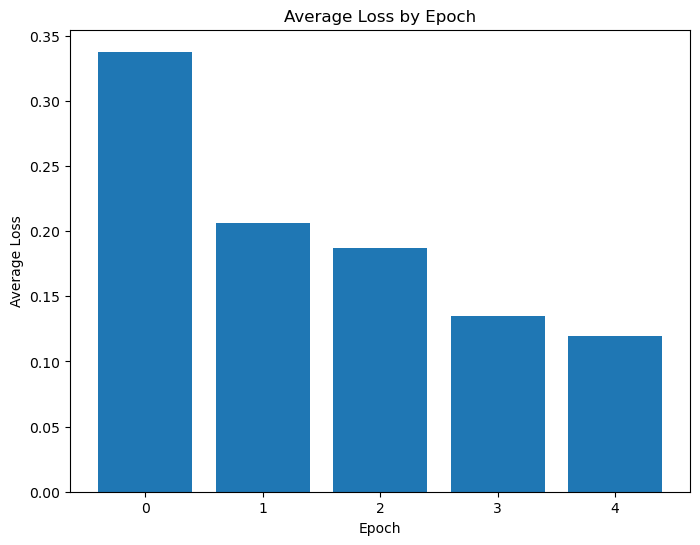

In [103]:
fig, ax = plt.subplots(figsize=(8, 6))
average_by_epoch = [] 
for item in loss_by_epoch_mome: 
    average_by_epoch.append(statistics.mean(item))
ax.bar(range(len(average_by_epoch)), average_by_epoch)

# Adding labels
ax.set_xlabel('Epoch')
ax.set_ylabel('Average Loss')
ax.set_title('Average Loss by Epoch')

Text(0.5, 1.0, 'Average Loss by Epoch MOME')

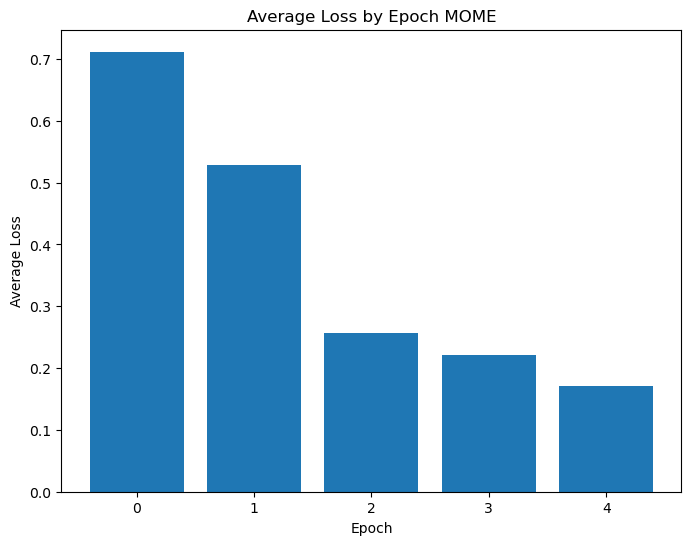

In [104]:
fig, ax = plt.subplots(figsize=(8, 6))
average_by_epoch = [] 
for item in loss_by_epoch: 
    average_by_epoch.append(statistics.mean(item))
ax.bar(range(len(average_by_epoch)), average_by_epoch)

# Adding labels
ax.set_xlabel('Epoch')
ax.set_ylabel('Average Loss')
ax.set_title('Average Loss by Epoch MOME')

NameError: name 'loss_by_epoch_soup' is not defined

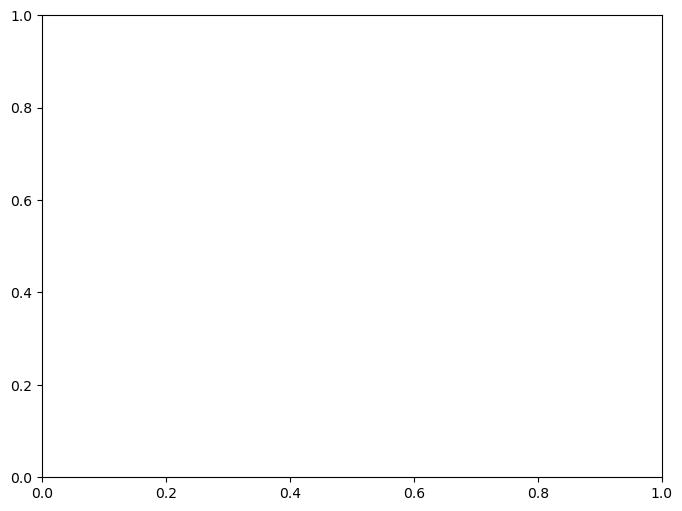

In [105]:
fig, ax = plt.subplots(figsize=(8, 6))
average_by_epoch = [] 
for item in loss_by_epoch_soup: 
    average_by_epoch.append(statistics.mean(item))
ax.bar(range(len(average_by_epoch)), average_by_epoch)

# Adding labels
ax.set_xlabel('Epoch')
ax.set_ylabel('Average Loss')
ax.set_title('Average Loss by Epoch Soup')

Text(0.5, 1.0, 'Loss Over Time MOME')

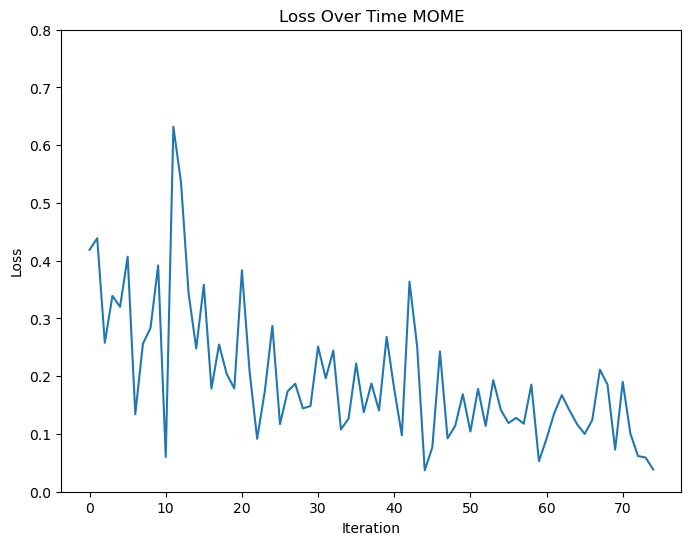

In [106]:
# plot loss over time
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(range(len(loss_hist_mome)), loss_hist_mome)
ax.set_ylim((0,.8))

# Adding labels
ax.set_xlabel('Iteration')
ax.set_ylabel('Loss')
ax.set_title('Loss Over Time MOME')

Text(0.5, 1.0, 'Loss Over Time')

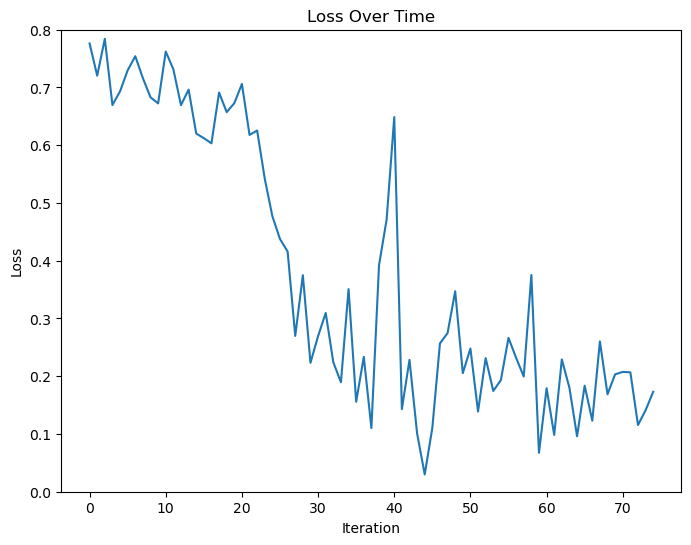

In [107]:
# plot loss over time
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(range(len(loss_hist)), loss_hist)
ax.set_ylim((0,.8))

# Adding labels
ax.set_xlabel('Iteration')
ax.set_ylabel('Loss')
ax.set_title('Loss Over Time')

Text(0.5, 1.0, 'Loss Over Time Soup')

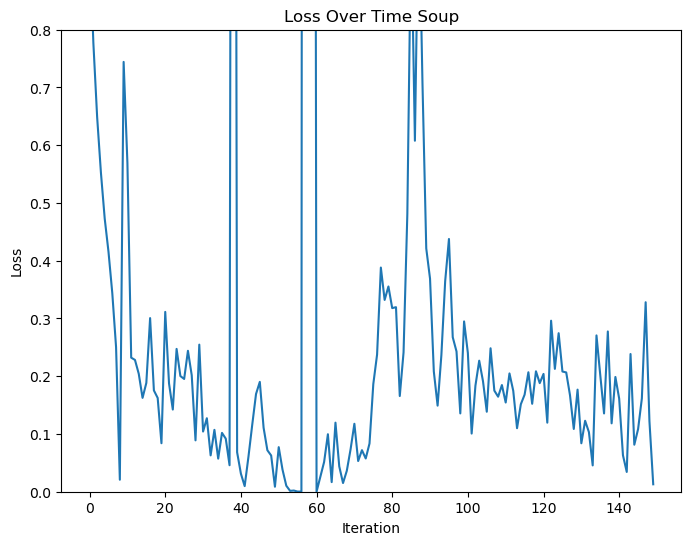

In [ ]:
# plot loss over time
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(range(len(loss_hist_soup)), loss_hist_soup)
ax.set_ylim((0,.8))

# Adding labels
ax.set_xlabel('Iteration')
ax.set_ylabel('Loss')
ax.set_title('Loss Over Time Soup')

In [ ]:
def reject_outliers(data, m = 2.):
    d = np.abs(data - np.median(data))
    mdev = np.median(d)
    s = d/mdev if mdev else np.zeros(len(d))
    return data[s<m]

In [ ]:
mean = np.mean(reject_outliers(np.array(loss_hist)))
print(mean)

0.03539670960502961


In [ ]:
mean_soup = np.mean(reject_outliers(np.array(loss_hist_soup)))
print(mean_soup)

0.15590591219616895


In [ ]:
print((mean - mean_soup) / mean)

-3.4045312102686482


C:\Users\elmig\AppData\Local\Temp\ipykernel_9720\1184206788.py:5: RankWarning: Polyfit may be poorly conditioned
  z = np.polyfit(x, loss_hist_mome, 20)
C:\Users\elmig\AppData\Local\Temp\ipykernel_9720\1184206788.py:15: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


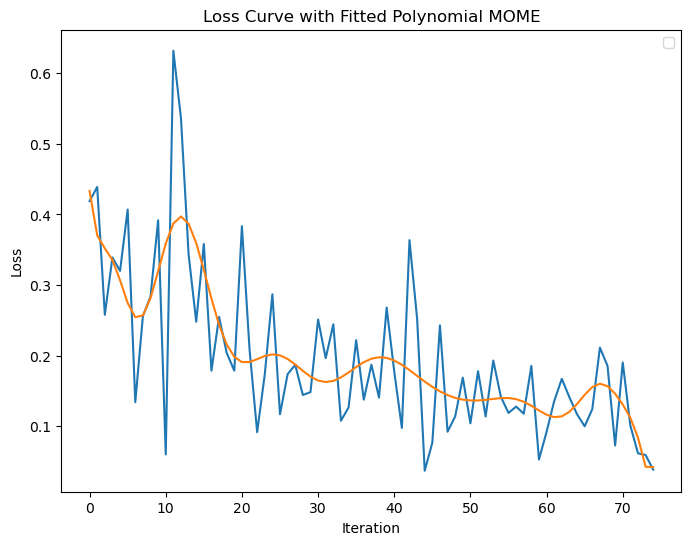

In [108]:
# loss curve 
fig, ax = plt.subplots(figsize=(8, 6))
x = range(len(loss_hist_mome))

z = np.polyfit(x, loss_hist_mome, 20)
p = np.poly1d(z)
ax.plot(x, loss_hist_mome, p(x))

# Adding labels
ax.set_xlabel('Iteration')
ax.set_ylabel('Loss')
ax.set_title('Loss Curve with Fitted Polynomial MOME')

# Add a legend
ax.legend()

C:\Users\elmig\AppData\Local\Temp\ipykernel_9720\2891919808.py:5: RankWarning: Polyfit may be poorly conditioned
  z = np.polyfit(x, loss_hist, 20)
C:\Users\elmig\AppData\Local\Temp\ipykernel_9720\2891919808.py:15: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


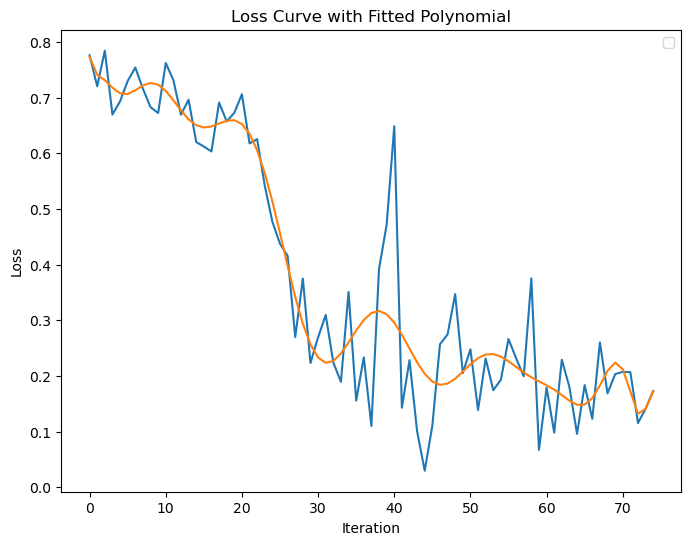

In [109]:
# loss curve 
fig, ax = plt.subplots(figsize=(8, 6))
x = range(len(loss_hist))

z = np.polyfit(x, loss_hist, 20)
p = np.poly1d(z)
ax.plot(x, loss_hist, p(x))

# Adding labels
ax.set_xlabel('Iteration')
ax.set_ylabel('Loss')
ax.set_title('Loss Curve with Fitted Polynomial')

# Add a legend
ax.legend()

C:\Users\elmig\AppData\Local\Temp\ipykernel_47148\1886567468.py:5: RankWarning: Polyfit may be poorly conditioned
  z = np.polyfit(x, loss_hist_soup, 20)
C:\Users\elmig\AppData\Local\Temp\ipykernel_47148\1886567468.py:16: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


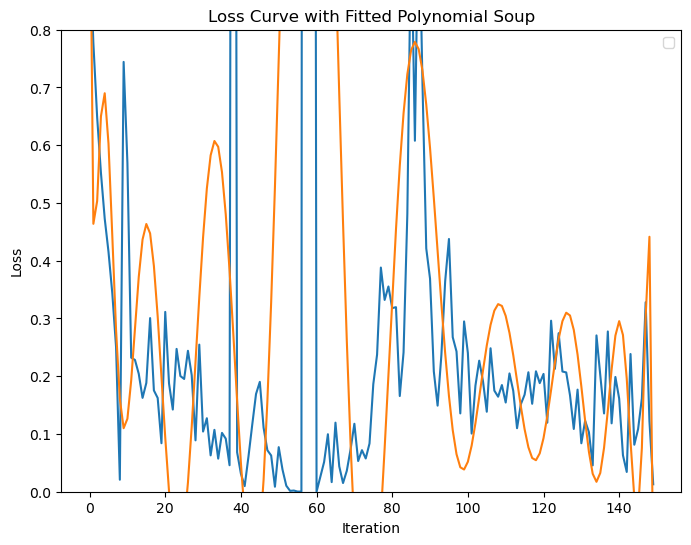

In [ ]:
# loss curve 
fig, ax = plt.subplots(figsize=(8, 6))
x = range(len(loss_hist_soup))

z = np.polyfit(x, loss_hist_soup, 20)
p = np.poly1d(z)
ax.plot(x, loss_hist_soup, p(x))

# Adding labels
ax.set_xlabel('Iteration')
ax.set_ylabel('Loss')
ax.set_title('Loss Curve with Fitted Polynomial Soup')
ax.set_ylim((0, .8))

# Add a legend
ax.legend()

In [110]:
def print_batch_accuracy(data, targets, net, train=False):
    output, _ = net(data.view(batch_size, -1))
    _, idx = output.sum(dim=0).max(1)
    acc = np.mean((targets == idx).detach().cpu().numpy())

    if train:
        print(f"Train set accuracy for a single minibatch: {acc*100:.2f}%")
    else:
        print(f"Test set accuracy for a single minibatch: {acc*100:.2f}%")

In [111]:
def eval_loop(data_eval, model):
    f1_score = []
    accuracy = []
    preds = [] 
    spike_counts = []
    net.eval()
    for item, targets in iter(data_eval):
        targets = targets[0:batch_size, 1:2]
        targets = targets.flatten()
        targets = targets.type(torch.long)

        #Get predictions
        spk_rec, mem_rec = model(item)
        spike_counts = spike_counts + count_spike(spk_rec).tolist()

        #Convert to binary 
        pred = torch.argmax(mem_rec.detach(), dim=1)
        # Calculate metrics 



        f1_score.append(metrics.f1_score(targets.detach(), pred))
        accuracy.append(metrics.accuracy_score(targets.detach(), pred))
        preds.extend(pred.tolist())

    net.train()
    return(spike_counts, preds, f1_score, accuracy)

In [112]:
eval_set = build_dataloader("Datasets/rat_pd_sim_data/VariedData")

torch.Size([738, 500, 80])


In [113]:
spike_count, model_predictions, f1_score, accuracy = eval_loop(eval_set, net)

In [114]:
spike_count_soup, model_predictions_soup, f1_score_soup, accuracy_soup = eval_loop(eval_set, mome_net)

In [115]:
print(model_predictions)

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 

[6013.0, 7979.0, 6324.0, 12267.0, 4181.0, 11311.0, 5720.0, 13938.0, 7161.0, 12356.0, 9039.0, 6445.0, 12386.0, 7143.0, 5474.0, 8613.0, 5031.0, 7728.0, 13097.0, 8607.0, 12405.0, 13045.0, 4853.0, 6937.0, 8988.0, 6724.0, 10021.0, 10696.0, 14091.0, 14592.0, 14862.0, 12664.0, 13773.0, 8178.0, 12440.0, 6233.0, 10154.0, 10499.0, 5953.0, 5991.0, 12277.0, 12622.0, 12518.0, 12035.0, 12023.0, 9298.0, 5007.0, 8116.0, 14196.0, 8226.0, 10809.0, 9219.0, 7373.0, 11095.0, 7900.0, 10720.0, 6384.0, 6437.0, 12322.0, 13292.0, 14293.0, 4354.0, 6904.0, 3178.0, 14223.0, 6438.0, 12191.0, 13865.0, 4253.0, 4248.0, 16076.0, 5694.0, 12900.0, 5741.0, 4365.0, 12655.0, 9292.0, 2904.0, 11470.0, 10838.0, 2599.0, 14538.0, 3987.0, 13894.0, 5721.0, 11848.0, 10023.0, 13679.0, 14414.0, 3690.0, 4098.0, 6153.0, 3171.0, 10537.0, 12796.0, 10844.0, 13391.0, 3500.0, 8570.0, 12002.0, 7354.0, 4130.0, 15132.0, 7580.0, 12954.0, 3265.0, 15170.0, 6626.0, 14909.0, 10316.0, 13525.0, 15237.0, 4639.0, 7461.0, 14378.0, 8849.0, 12743.0, 14674

Text(0.5, 1.0, 'Spike Count by Data Point')

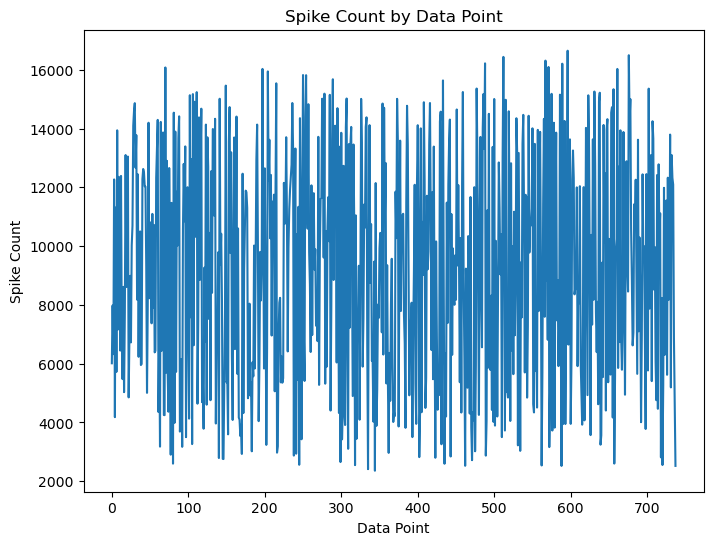

In [116]:
fig, ax = plt.subplots(figsize=(8, 6))
print(spike_count)
ax.plot(range(len(spike_count)), spike_count)

# Adding labels
ax.set_xlabel('Data Point')
ax.set_ylabel('Spike Count')
ax.set_title('Spike Count by Data Point')

[1407.13916015625, 1235.9541015625, 3068.69921875, 1112.394775390625, 2658.592529296875, 1524.7196044921875, 2648.91748046875, 3462.15087890625, 1393.5394287109375, 3269.30810546875, 2774.351806640625, 1823.133544921875, 3137.1318359375, 1328.5548095703125, 1308.218017578125, 1809.1229248046875, 2675.3212890625, 1116.72900390625, 1644.0413818359375, 1292.663330078125, 1750.2381591796875, 1265.1312255859375, 2836.935546875, 1861.9669189453125, 1692.65234375, 2061.3740234375, 1169.89453125, 1324.3641357421875, 2405.435791015625, 1282.31884765625, 2363.353759765625, 1443.837646484375, 1807.3739013671875, 1466.029541015625, 1681.0826416015625, 2433.664306640625, 2600.58251953125, 1170.1546630859375, 2673.6181640625, 3114.02734375, 1956.8721923828125, 1382.631103515625, 1629.7489013671875, 1432.733642578125, 2349.617431640625, 1880.3363037109375, 2156.153076171875, 1177.8358154296875, 1265.54931640625, 1780.0133056640625, 1149.5108642578125, 1240.287353515625, 1534.78955078125, 2830.6198730

Text(0.5, 1.0, 'Spike Count by Data Point Soup')

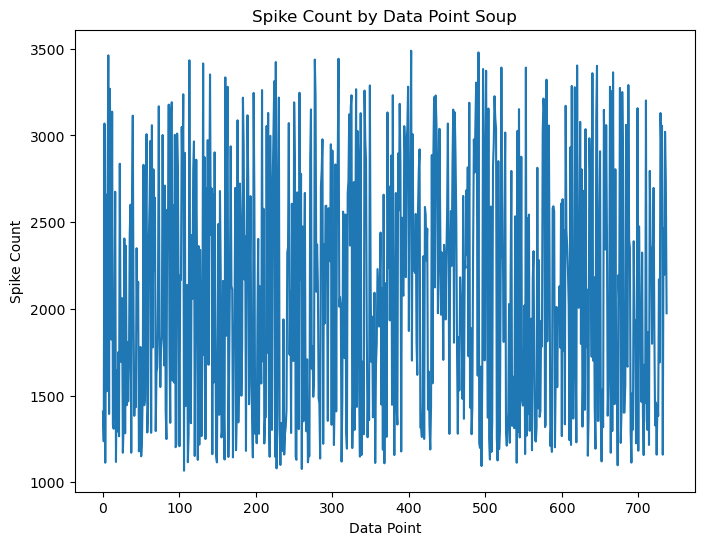

In [117]:
fig, ax = plt.subplots(figsize=(8, 6))
print(spike_count_soup)
ax.plot(range(len(spike_count_soup)), spike_count_soup)

# Adding labels
ax.set_xlabel('Data Point')
ax.set_ylabel('Spike Count')
ax.set_title('Spike Count by Data Point Soup')

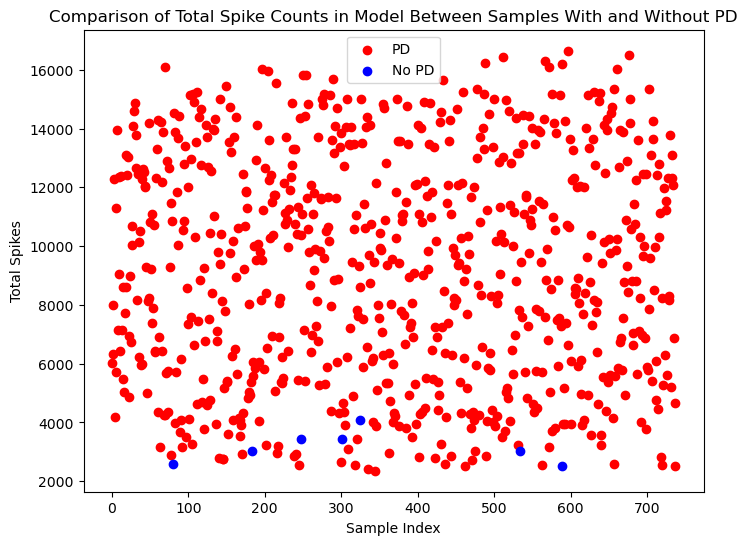

In [118]:
pd_spike_counts = []
pd_indexes = [] 
con_spike_counts = []
con_indexes = []  
count = 0 


for i in range(len(spike_count)): 
    if model_predictions[i] == 1: 
        pd_spike_counts.append(spike_count[i])
        pd_indexes.append(count) 
    else: 
        con_spike_counts.append(spike_count[i])
        con_indexes.append(count)
    count += 1 

fig, ax = plt.subplots(figsize=(8, 6))
#plt.setp(ax, xticks=range(max(len(no_pd_labels), len(pd_labels))))
ax.scatter(pd_indexes, pd_spike_counts, color='red', label='PD')
ax.scatter(con_indexes, con_spike_counts, color='blue', label='No PD')

ax.set_xlabel('Sample Index')
ax.set_ylabel('Total Spikes')
ax.set_title('Comparison of Total Spike Counts in Model Between Samples With and Without PD')
ax.legend()
plt.show()

Text(0.5, 1.0, 'Mean Spike Count by Batch')

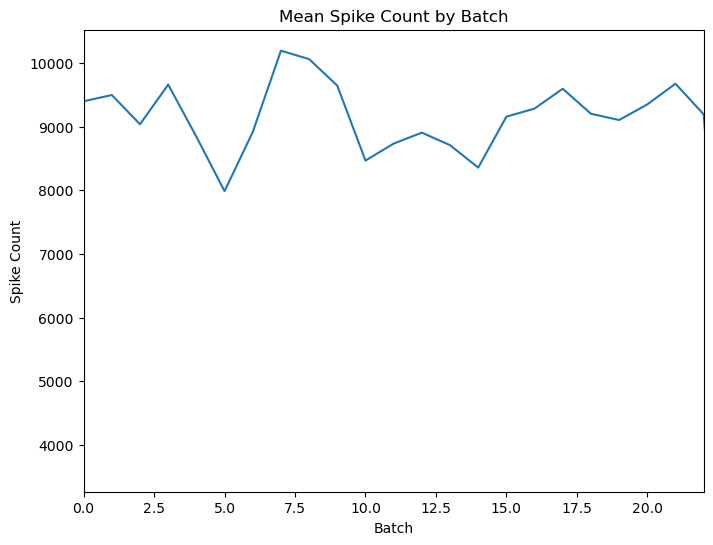

In [138]:
fig, ax = plt.subplots(figsize=(8, 6))
spike_count_average_by_epoch = [np.mean(spike_count[i:i+batch_size]) for i in range(0,len(spike_count),batch_size)]
ax.plot(range(len(spike_count_average_by_epoch)), spike_count_average_by_epoch)

# Adding labels
ax.set_xlabel('Batch')
ax.set_ylabel('Spike Count')
ax.set_xlim(0, 22)
ax.set_title('Mean Spike Count by Batch')

In [120]:
mean = np.mean(spike_count_average_by_epoch)
print(mean)

8938.095052083334


Text(0.5, 1.0, 'Mean Spike Count by Batch: MOME')

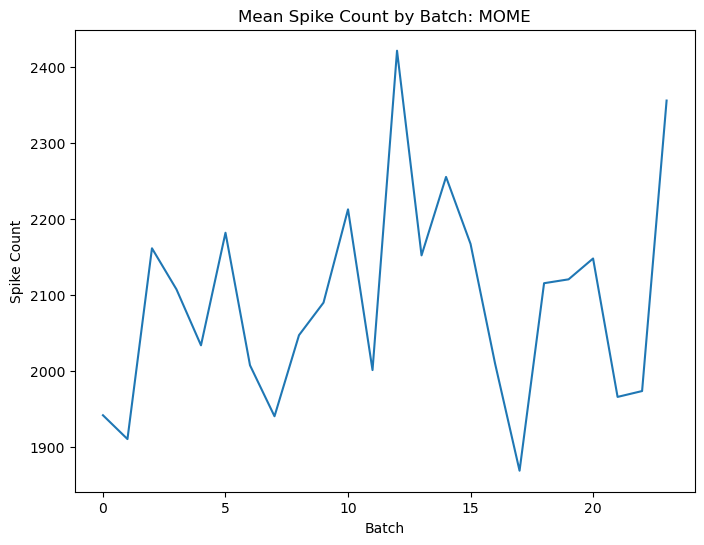

In [126]:
fig, ax = plt.subplots(figsize=(8, 6))
spike_count_average_by_epoch_soup = [np.mean(spike_count_soup[i:i+batch_size]) for i in range(0,len(spike_count_soup),batch_size)]
ax.plot(range(len(spike_count_average_by_epoch_soup)), spike_count_average_by_epoch_soup)

# Adding labels
ax.set_xlabel('Batch')
ax.set_ylabel('Spike Count')
ax.set_title('Mean Spike Count by Batch: MOME')

In [122]:
mean_soup = np.mean(spike_count_average_by_epoch_soup)
print(mean_soup)

2091.314119497935


In [123]:
print((mean - mean_soup) / mean)

0.7660223898591814


Text(0.5, 1.0, 'F1 Score by Batch')

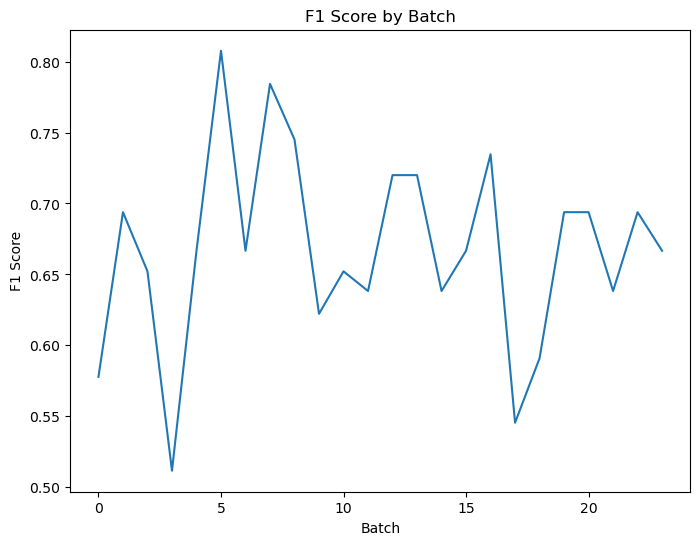

In [124]:
# Plot f1 
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(range(len(f1_score)), f1_score)

# Adding labels
ax.set_xlabel('Batch')
ax.set_ylabel('F1 Score')
ax.set_title('F1 Score by Batch')

Text(0.5, 1.0, 'Accuracy by Batch')

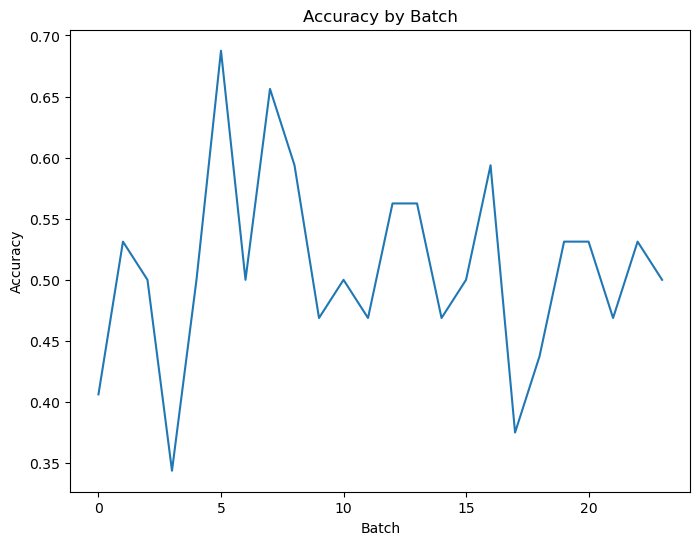

In [125]:
# Plot accuracy
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(range(len(accuracy)), accuracy)

# Adding labels
ax.set_xlabel('Batch')
ax.set_ylabel('Accuracy')
ax.set_title('Accuracy by Batch')